# `pymssa` Readme and User Guide
---

The `pymssa` package implements Multivariate Singular Spectrum Analysis in python. As of the time of this writing, I am not aware of any other implementation in python of *multivariate* SSA, though there are packages and implementations of univariate SSA. R on the other hand has the extremely comprehensive `Rssa` package for performing MSSA and its variants. 

This is definitely not as comprehensive as the `Rssa` package (which I believe is maintained by the creator of SSA), but it implements the fundamental components of MSSA. As of the time of this writing, the `MSSA` class features:
- Uni- or Multi-variate decomposition of timeseries using Singular Spectrum Analysis
- Automated options for selection of number of components:
    - Variance explained thresholding
    - Parallel analysis
    - Singular Value Hard Thresholding
- Calculation of the w-correlation matrix of component correlations.
- Easy interface to assign and retrieve component groupings.
- Easy accesss via attributes to:
    - MSSA component matrix (or "reconstructions")
    - Left singular vectors and singular values
    - Explained variance scores and percent variance explained for components
    - Per-timeseries component rankings by variance explained/reconstruction error.
- Recurrent forecasting function. You specify timepoints out and optionally which timeseries and with which components to forecast with.

## `pymssa` Uses `numba`-optimized Functions *(where possible)*

While the `MSSA` class provides the main interface to the MSSA algorithm and tools, you will notice if you look through the code that the majority of the actual functions and math are imported from the `optimized` submodule. MSSA can be pretty slow and memory intensive, especially if you are dealing with large timeseries data. Where possible, I've converted the operations to `numba`-compiled functions that significantly speed up the algorithm. I've also tried to organize the loops, initializations, and intermediary steps in such a way that will minimize the memory required.

With a large enough dataset you will still run into problems, particularly for the SVD steps and reconstruction of components steps, despite the optimizations. At a certain point I'm not sure if there are ways around this or if you just need a bigger computer. I am not a code optimization expert, so any contributions that help with this are more than welcome! See the **Contributing** section for more ideas if you're interested in adding to this package.


    

---

# Demo of `MSSA` on Austrailian Wine Dataset

To demonstrate the features of the `MSSA` class, and provide a general walkthrough of the steps involved in a standard multivariate singular spectrum analysis, I will load an example dataset that comes packaged with the `Rssa` R package.

This data has 7 timeseries and 187 observations (some of which are null values). It is monthly data spanning from 1980 to 1995, and tracks sales of Austrailian wine. The columns are types of wine, including:
- Total
- Drywhite
- Fortified
- Red
- Rose
- Sparkling
- Sweetwhite

You can see the header of this dataset below.

In [62]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import r2_score

In [63]:
wine_raw = pd.read_csv('wine.csv',encoding="utf-8").iloc[:,1:]
wine = wine_raw[['Total','Drywhite','Fortified','Red','Rose','Sparkling','Sweetwhite']]
date_index = pd.date_range(start='1/1/1980', periods=wine.shape[0], freq='M')
wine.index = date_index
wine.head()

FileNotFoundError: [Errno 2] No such file or directory: 'wine.csv'

## A Brief Note on the Math and Algorithms in MSSA

I've chosen not to cover the math behind MSSA in this demo. There are many resources online and I would prefer this user guide to focus on the usage and implementation of MSSA in this package. However, for those in need of a reference there are two resources in particular that I think are very informative:
- For an overview of the math and walkthrough of the code behind singular spectrum analysis I highly recommend this blog post by Jordan D'Arcy: [Introducing SSA for Time Series Decomposition](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition). It is probably the best walkthrough of SSA that I have seen so far. It is for univariate SSA rather than multivariate SSA, but the concepts and math are essentially the same for both. 
- For the multivariate case, a fairly detailed overview of the math, trajectory matrix construction, and forecasting algorithm can be found in this paper available on Researchgate: [Multivariate singular spectrum analysis: A general view and new vector forecasting approach](https://www.researchgate.net/publication/263870252_Multivariate_singular_spectrum_analysis_A_general_view_and_new_vector_forecasting_approach). The implementation here corresponds to the vertical formulation of MSSA (V-MSSA), which the authors in that paper argue is superior in performance to the horizontal forumlation. The forecasting in this package follows the recurrent forecasting formula for VMSSA. I would like to eventually have the vector forecasting method implemented as well, but have not coded it yet. See the **Contributing** section for this and more ideas if you'd like to add it.

저는 이 데모에서 MSSA의 수학은 다루지 않기로 했습니다. 온라인에는 많은 리소스가 있으며 본 사용자 가이드는 이 패키지의 MSSA 사용 및 구현에 초점을 맞추었으면 합니다. 그러나 참조가 필요한 사람들에게 매우 유익하다고 생각하는 두 가지 자료가 있습니다.

- 단수 스펙트럼 분석 뒤에 있는 코드의 수학 개요 및 검토에 대해 Jordan D'Arcy의 블로그 게시물 [시계열 분해에 대한 SSA 소개](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition)를 적극 권장한다. 아마도 지금까지 본 SSA 중 가장 잘한 산책일 것이다. 다변량 SSA보다는 일변량 SSA를 위한 것이지만, 개념과 수학은 본질적으로 둘 다 같습니다. 
- 다변량 사례의 경우, 수학, 궤적 행렬 구성 및 예측 알고리즘에 대한 상당히 상세한 개요는 Researchgate에서 이용할 수 있는 본 논문에서 확인할 수 있다. [다변량 단수 스펙트럼 분석: 일반적인 관점 및 새로운 벡터 예측 접근법](https://www.researchgate.net/publication/263870252_Multivariate_singular_spectrum_analysis_A_general_view_and_new_vector_예측_approach). 여기서 구현은 MSSA(V-MSSA)의 수직적 공식화에 해당하며, 이 논문의 저자들은 수평적 포럼화보다 성능이 우수하다고 주장한다. 이 패키지의 예측은 VMSA의 반복 예측 공식을 따릅니다. 최종적으로 벡터 예측법도 구현하고 싶지만 아직 코딩하지 않았습니다. 추가하려는 경우 **기여* 절과 더 많은 아이디어를 참조하십시오.

## Centering and Splitting the Data

In order to validate the forecasting we will do at the end, I am going to split the wine data into training and testing. I've chosen to leave off 48 months, or 4 years of wine sales data, to serve as my holdout test set for validation.

There are some null values in the dataset, but they all happen to occur in the most recent 48 months, which we are leaving off for testing. This is nice since we only need to worry about null values in the training set. They are fine to occur in the testing set, we will just have fewer values in some cases to calculate our performance metric.

마지막에 우리가 할 예측을 검증하기 위해 와인 데이터를 교육과 테스트로 나누려고 합니다. 저는 검증을 위한 홀드아웃 테스트 세트의 역할을 하기 위해 48개월 또는 4년간의 와인 판매 데이터를 보류하기로 결정했습니다.

데이터셋에 null 값이 있지만 모두 최근 48개월 사이에 발생하므로 테스트하지 않습니다. 트레이닝 세트에서 null 값만 신경 쓰면 되니까 다행이네요. 테스트 세트에서 발생해도 괜찮습니다. 경우에 따라 성능 메트릭을 계산할 수 있는 값이 더 적습니다.

In [15]:
tp = 48

wine_tr = wine.iloc[:-tp]
wine_te = wine.iloc[-tp:]

TP : 48개를 중심으로 쪼갠다
TR : training 데이터셋
TE : test 데이터셋

I'm also going to center the data. If you do not center the data then the first component is just going to end up being the offset that centers the reconstruction anyway. There is no reason not to just deal with it prior to the decomposition.

> *Note: you may also choose to standardize the data by also dividing by the standard deviation. I've chosen not to do this here just to keep things on their original scale, but standardization is a good preprocessing step to do prior to decomposition to ensure that the contribution of variance by each timeseries is on equal ground.*

제가 데이터 센터링도 할 예정입니다. 데이터를 가운데에 배치하지 않으면 첫 번째 구성요소는 결국 재구성의 가운데에 있는 오프셋이 됩니다. 부패하기 전에 처리하지 않을 이유가 없다.

> *참고: 데이터를 표준 편차로 나누어 표준화할 수도 있습니다. 여기서는 원래 척도로 유지하기 위해 이 작업을 수행하지 않기로 선택했지만, 표준화는 분해 전에 각 시계열의 분산 기여도가 동일한 지면에 있도록 하는 좋은 사전 처리 단계입니다.*

In [16]:
tr_means = np.nanmean(wine_tr, axis=0)
wine_tr = wine_tr - tr_means
wine_te = wine_te - tr_means

## Fitting with `MSSA`

Now we can instantiate the `MSSA` object and fit to the training data. There are a handful of instantiation arguments that we will cover incrementally over the course of this demo. They are:
- `window_size`
- `n_components`
- `variance_explained_threshold`
- `pa_percentile_threshold`
- `svd_method`
- `varimax` (experimental)
- `verbose`

The only option that I will not be covering in the demo is `varimax`, which is designed to perform a structured varimax on the left singular values after decomposition to "sparsify" the components. This is experimental and I'm not totally confident its doing what its supposed to yet, so I am going to leave it out of this demo for now.

In [21]:
%cd ..

C:\Users\qhrrl\CodeExamples\3.Paper\3.SSA-TR\pymssa


In [22]:
%ls

 C 드라이브의 볼륨: OS
 볼륨 일련 번호: 1CE6-F7EB

 C:\Users\qhrrl\CodeExamples\3.Paper\3.SSA-TR\pymssa 디렉터리

2022-02-20  오후 05:20    <DIR>          .
2022-02-20  오후 06:21    <DIR>          ..
2022-02-20  오후 05:20               315 .gitignore
2022-02-20  오후 07:22    <DIR>          examples
2022-02-20  오후 05:20             1,093 LICENSE
2022-02-20  오후 05:20    <DIR>          pymssa
2022-02-20  오후 05:20    <DIR>          pymssa.egg-info
2022-02-20  오후 05:20            34,817 README.md
2022-02-20  오후 05:20    <DIR>          README_files
2022-02-20  오후 05:20               884 setup.py
               4개 파일              37,109 바이트
               6개 디렉터리  287,888,834,560 바이트 남음


In [25]:
%pwd

'C:\\Users\\qhrrl\\CodeExamples\\3.Paper\\3.SSA-TR\\pymssa'

In [26]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing pymssa.egg-info\PKG-INFO
writing dependency_links to pymssa.egg-info\dependency_links.txt
writing requirements to pymssa.egg-info\requires.txt
writing top-level names to pymssa.egg-info\top_level.txt
reading manifest file 'pymssa.egg-info\SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'pymssa.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build
creating build\lib
creating build\lib\pymssa
copying pymssa\mssa.py -> build\lib\pymssa
copying pymssa\ops.py -> build\lib\pymssa
copying pymssa\optimized.py -> build\lib\pymssa
copying pymssa\__init__.py -> build\lib\pymssa
creating build\bdist.win-amd64
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\pymssa
copying build\lib\pymssa\mssa.py -> build\bdist.win-amd64\egg\pymssa
copying build\lib\pymssa\ops.py -> build\bdist.win-amd64\egg\pymssa
copying build\lib\pymssa\optimiz

In [34]:
from pymssa import MSSA

I'll instantiate the `MSSA` object with `n_components=None` and `window_size=None`. This will set the number of components to be the maximum number of components, and the window size to be the maximum window size.

`n_components` works the same as this option in scikit-learn's decomposition functions when the values are either `None` or an integer. As `None`, the maximum number will be selected, and as an integer only that number of components will be selected. There are also some other options for this argument to automate the selection of components that I will cover later in the demo.

In [35]:
mssa = MSSA(n_components=None,
            window_size=None,
            verbose=True)

### What does `window_size` do?

The `window_size` argument controls the shape of the "trajectory matrix" that is created out of each timeseries. Prior to singular value decomposition, the MSSA algorithm goes through these steps:
1. Convert each timeseries vector of length N to a trajectory matrix of shape (L, K), where L is the window size and K = N - L + 1. 
2. Stack the trajectory matrices vertically. 
3. Compute S = X X.T, where X is the vertically-stacked trajectory matrices. 
4. Perform SVD on the matrix S.

The idea of the trajectory matrix is to convert a timeseries vector into a matrix of incremental "windows" over the timeseries. This is what allows MSSA/SSA to capture signal in timeseries better than PCA would.

Imagine we have a timeseries vector of increasing numbers:

In [36]:
ts = np.arange(30)
ts

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

To convert `ts` to the trajectory matrix, we specify a window size and then take the transposition of the [hankel matrix](https://en.wikipedia.org/wiki/Hankel_matrix) of this timeseries.

In [37]:
window = 5
trajmat = scipy.linalg.hankel(ts, np.zeros(window)).T
trajmat = trajmat[:, :(30 - window + 1)]
trajmat

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.],
       [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
        17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.]])

You can see that the trajectory matrix has 5 rows (window length 5). Each column represents a window of width 5 moving across the timeseries one at a time until the end of the timeseries is reached. You can see this clearer looking at just the first 5 columns.

In [38]:
trajmat[:, :5]

array([[0., 1., 2., 3., 4.],
       [1., 2., 3., 4., 5.],
       [2., 3., 4., 5., 6.],
       [3., 4., 5., 6., 7.],
       [4., 5., 6., 7., 8.]])

### How to pick the `window_size`

There is unfortunately not an easy answer for picking the window size, or consensus on methodology for choosing one automatically. The general recommendation seems to be either:
- Pick the largest window size possible (maximum window size is N // 2). Note that as your data gets large, the maximum window size can be untenable due to the size of the matrix that must be decomposed by SVD, so take this approach with caution.
- Try out different window sizes to see what works best with your data.
- If your data has some known periodic structure (e.g. months in a year), use a multiple of this periodicity when selecting a window size.

There are some other more advanced methods not yet implemented in this package, like "Sequential SSA", which decomposes the timeseries at different window lengths to pull out different frequencies of signal, then combines the results. Something like that may become available in a future update.

### Fit on training

With `mssa` instantiated, just use the `fit` function to fit the decomposition on the training data.

In [39]:
mssa.fit(wine_tr)

Constructing trajectory matrix
Trajectory matrix shape: (483, 71)
Decomposing trajectory covariance matrix with SVD
Constructing components


C:\Users\qhrrl\CodeExamples\3.Paper\3.SSA-TR\pymssa\pymssa\optimized.py:228: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  components = _incremental_component_reconstruction_inner(


Calculating optimal reconstruction orders


Since `verbose=True` you can see the steps taken in the fit procedure. For this small dataset the steps are nearly instantaneous. With larger datasets the steps can often take much longer, even with the `numba` optimizations in place. 

In this case the `fit` function carries out these steps:
1. Construct the trajectory matrix.
2. Decompose with SVD
3. Construct the components
    - This is a two-step process. First create the "elementary matrices". These are the same shape as the trajectory matrix recreated from each of the left singular vectors. For each elementary matrix, reverse the hankelization back into a timeseries vector using a process called "diagonal averaging".
4. Calculate the optimal component ordering per timeseries. This calculates the ranking of how well each component explains the variance of the original timeseries (more on this later).

## Attributes available after running `fit`

Once the decomposition completes, you now have access to a variety of attributes on the object.

- `mssa.N_`
    - Observations in timeseries (rows).
- `mssa.P_`
    - Number of timeseries (columns).
- `mssa.L_`
    - Window size of trajectory matrices.
- `mssa.K_`
    - Column dimension of trajectory matrices.
- `mssa.rank_`
    - The selected rank (number of components kept)
- `mssa.left_singular_vectors_`
    - The left singular vectors from the decomposition of the covariance of trajectory matrices via SVD.
- `mssa.singular_values_`
    - Singular values from SVD
- `mssa.explained_variance_`
    - The explained variance of the SVD components
- `mssa.explained_variance_ratio_`
    - Percent of explained variance for each component
- `mssa.components_`
    - The MSSA components. This is the result of the decomposition and reconstruction via diagonal averaging. The sum of all the components for a timeseries (without reducing number of components) will perfectly reconstruct the original timeseries. The dimension of this matrix is (P, N, rank), where P is the number of timeseries, N is the number of observations, and rank is the number of components selected to keep.
- `mssa.component_ranks_`
    - This matrix shows the rank of each component per timeseries according to the reconstruction error. This is a (rank, P) matrix, with rank being the number of components and P the number of timeseries. For example, if component_ranks_[0, 0] = 3, this would mean that the 3rd component accounts for the most variance for the first timeseries.
- `mssa.component_ranks_explained_variance_`
    - This shows the explained variance percent for the ranked components per timeseries. Like component_ranks_, this is a (rank, P) matrix. The values in this matrix correspond to the percent of variance explained by components per timeseries in rank order of their efficiency in reconstructing the timeseries.

### The `.components_` attribute

Likely the result of most interest to you will be the reconstructed components available in the `.component_` attribute. As mentioned above, this is a matrix with dimensions (P, N, components), where P is the number of input timeseries columns, N the number of observations, and rank the number of components output.

We can see for example what the first 10 components look like for Red wine, which is timeseries index 3.

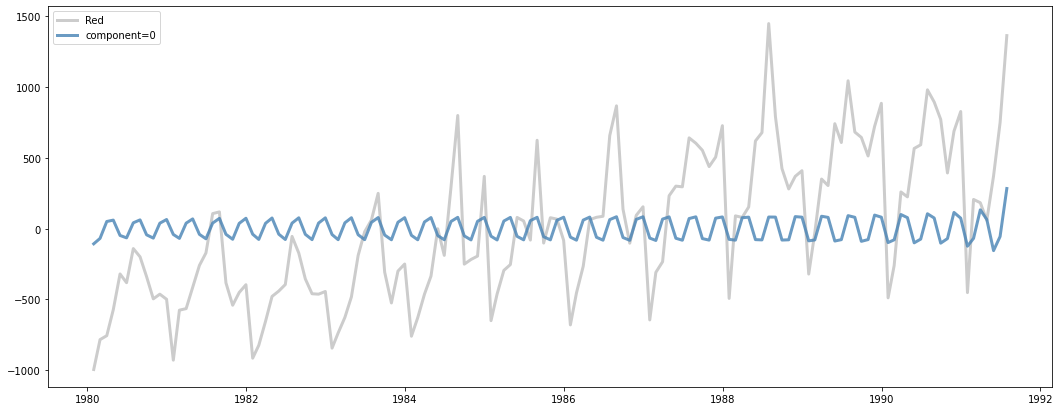

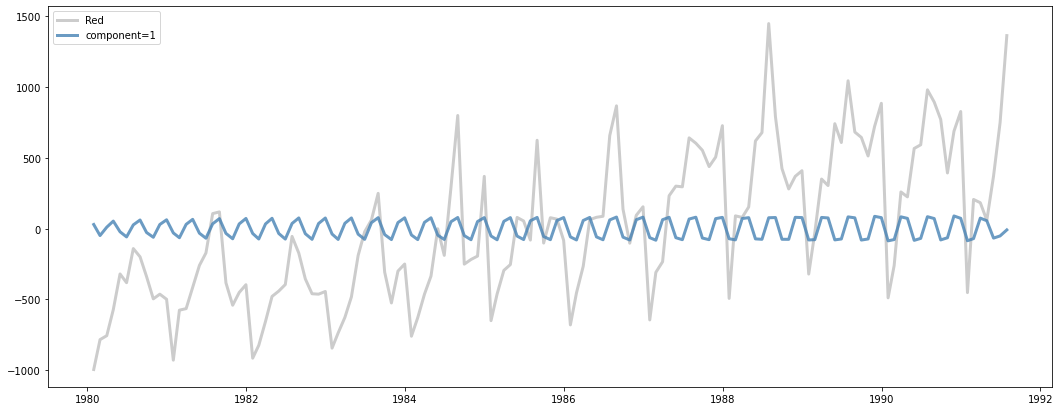

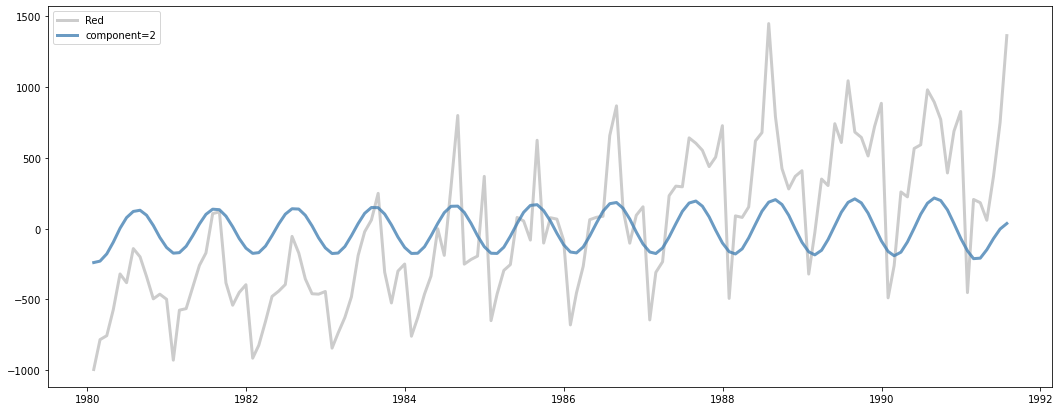

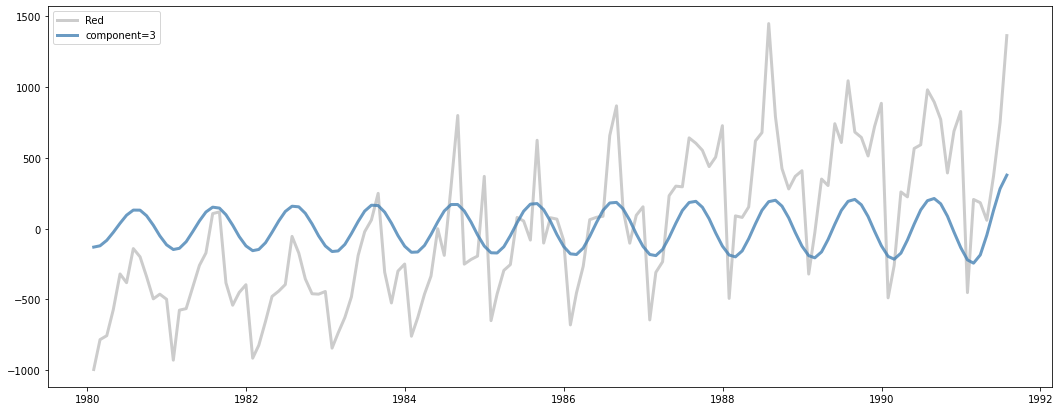

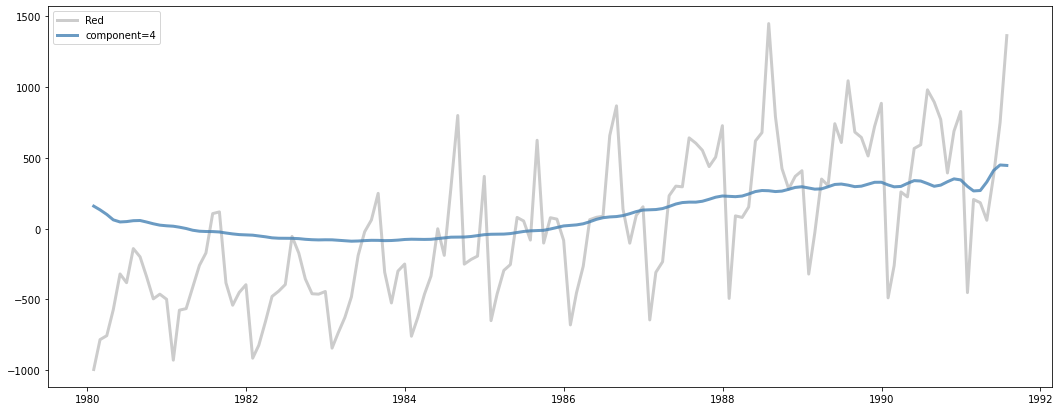

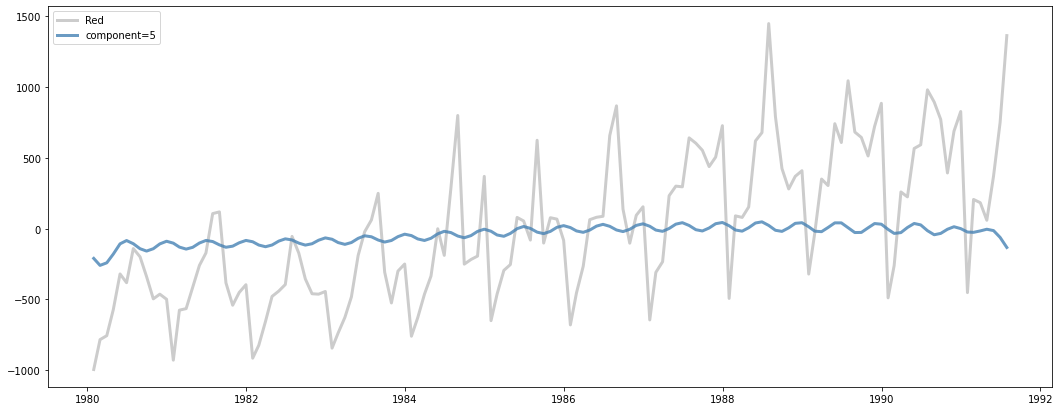

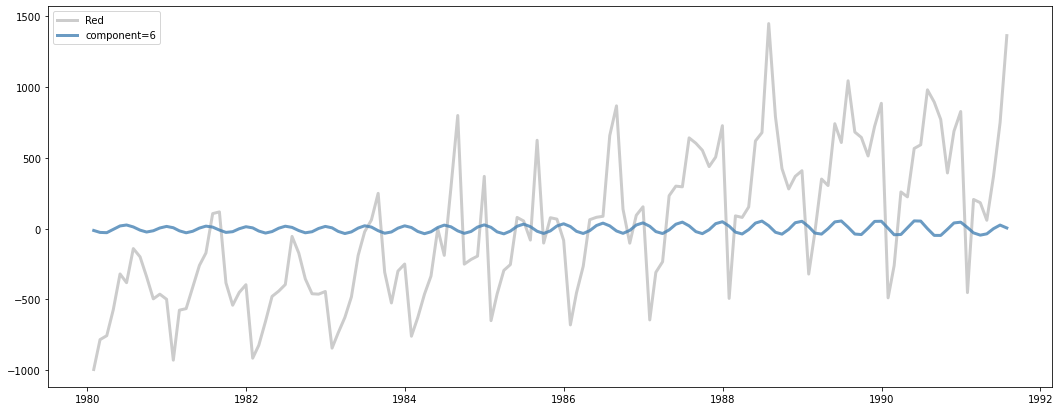

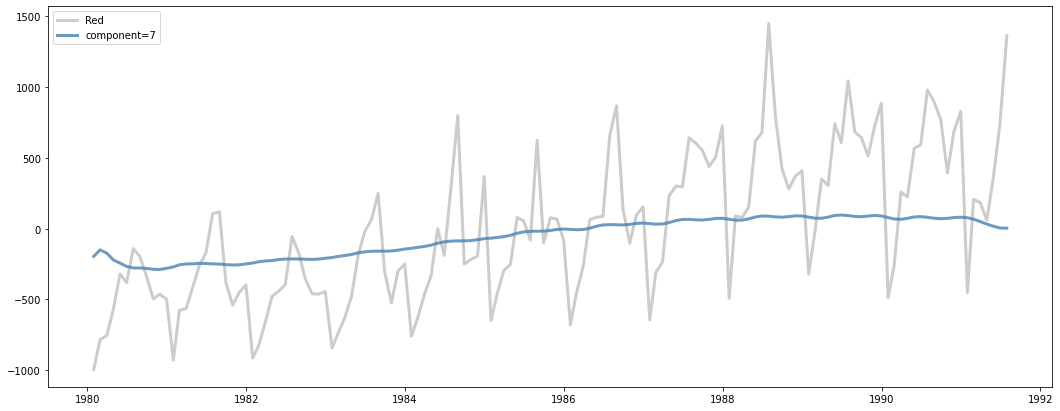

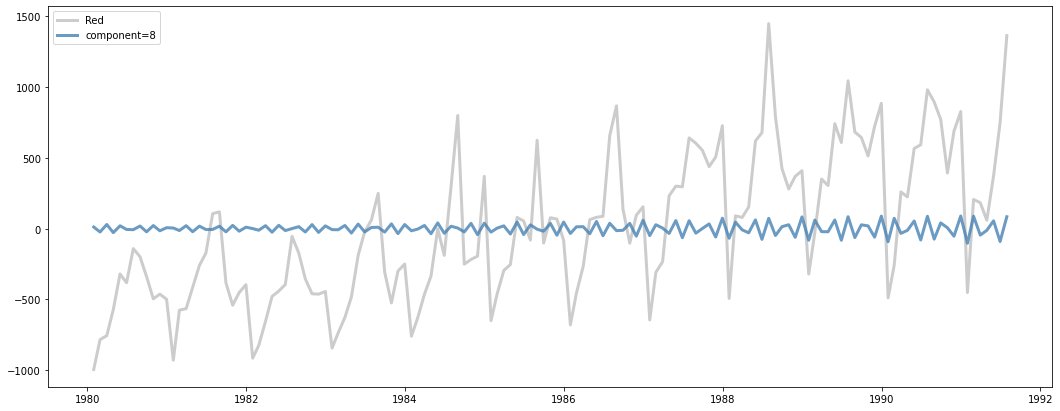

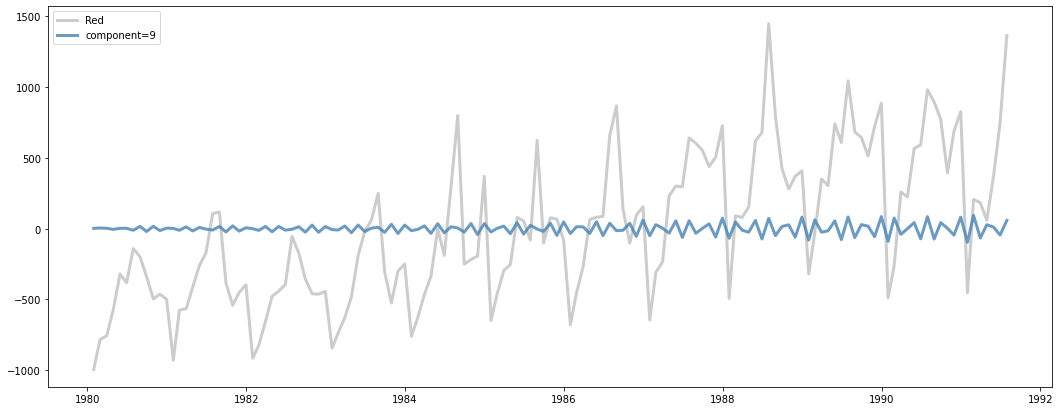

In [40]:
red_idx = 3

for comp in range(10):  
    fig, ax = plt.subplots(figsize=(18, 7))
    ax.plot(wine_tr.index, wine_tr.iloc[:, red_idx].values, lw=3, alpha=0.2, c='k', label=wine_tr.columns[red_idx])
    ax.plot(wine_tr.index, mssa.components_[red_idx, :, comp], lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    ax.legend()
    plt.show()

The components you get out of MSSA are additive in the sense that they will add back up to the original series. Each component may account for more or less variance of a given timeseries, though typically the first components will account for more variance than later components (the actual order of which components account for most variance per timeseries can be found in `component_ranks_`).

We can overlay the cumulative sum of the components as we iterate through to show how the original timeseries gets incrementally better reconstructed.

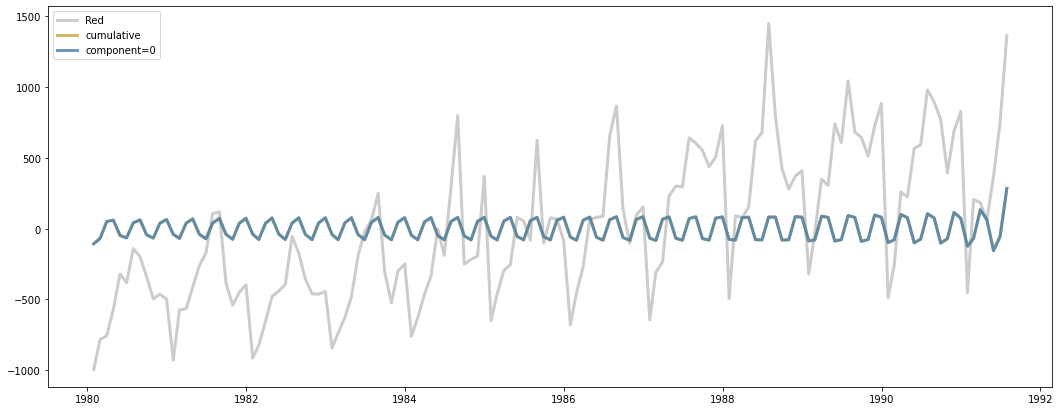

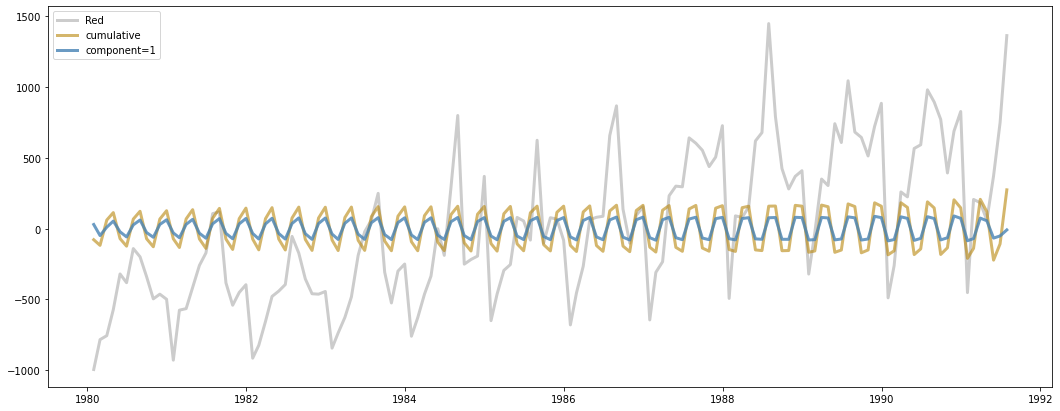

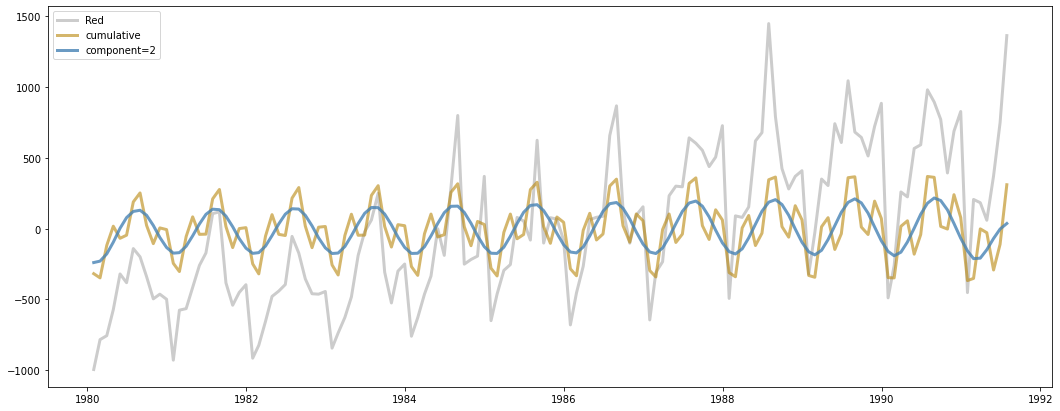

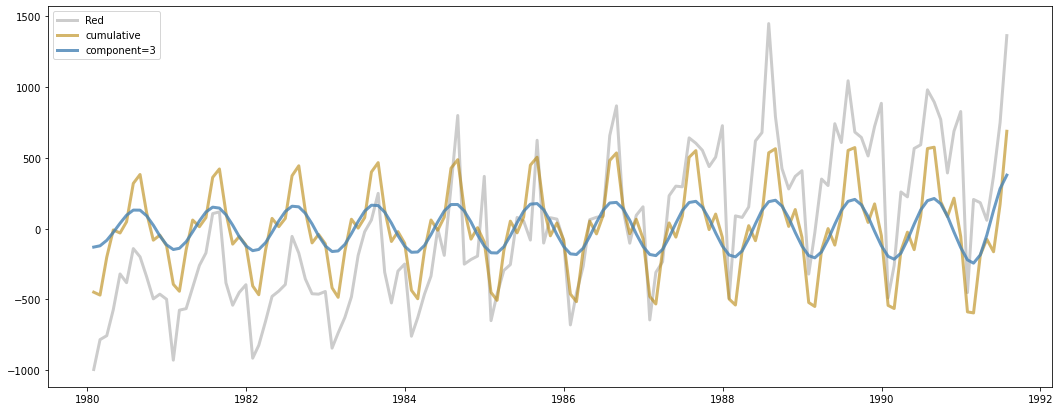

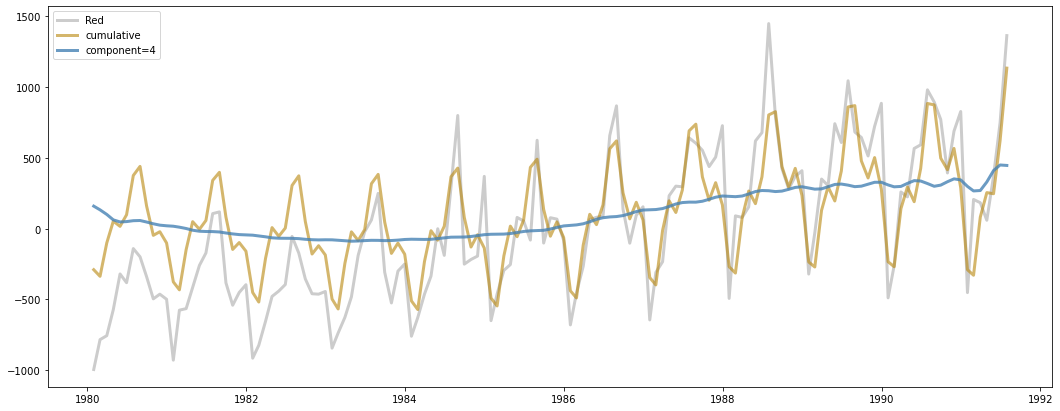

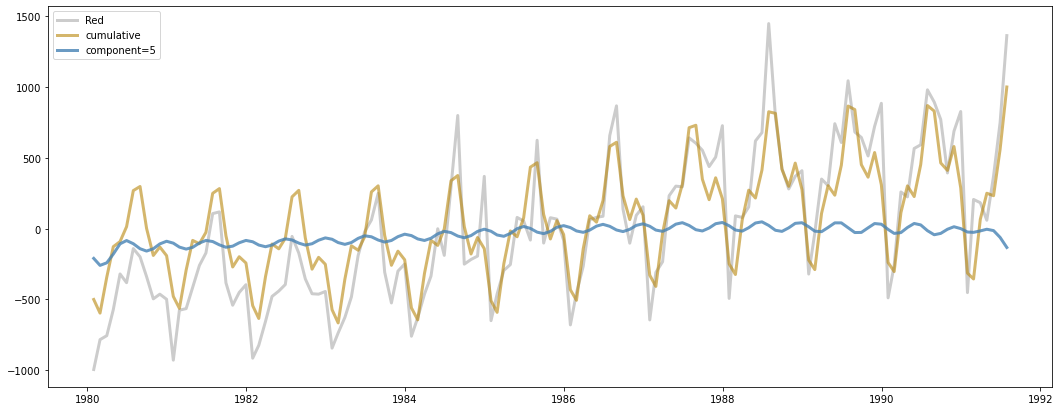

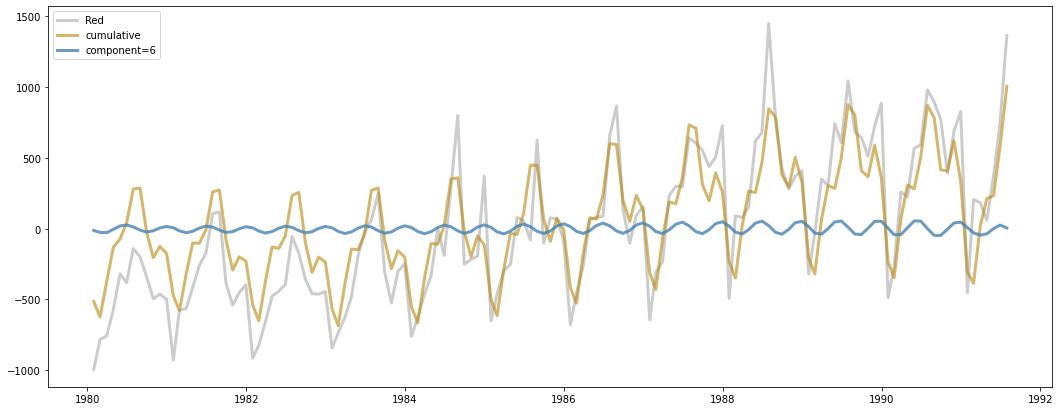

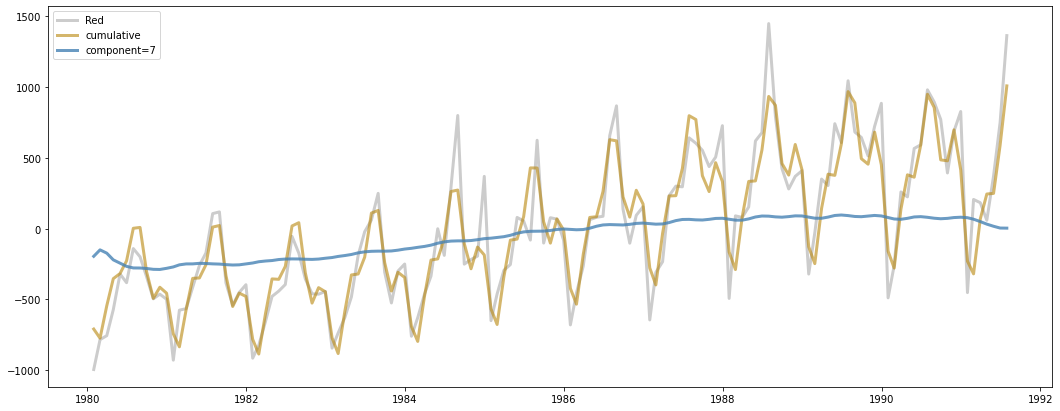

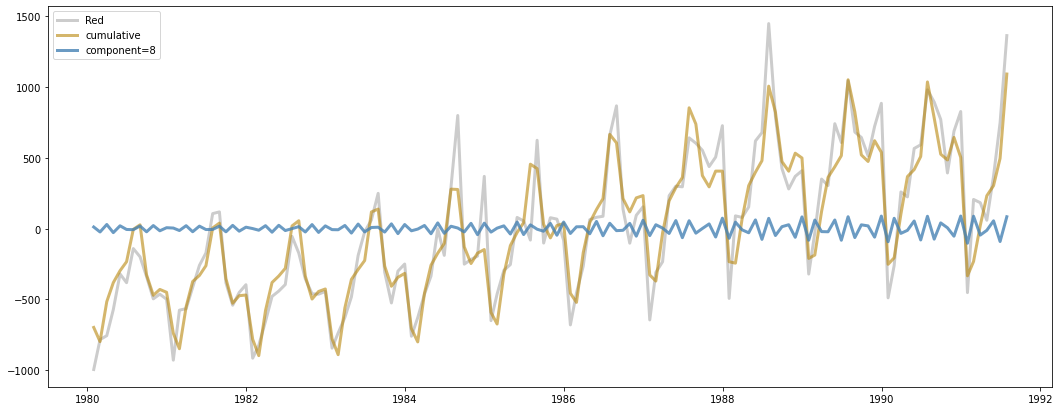

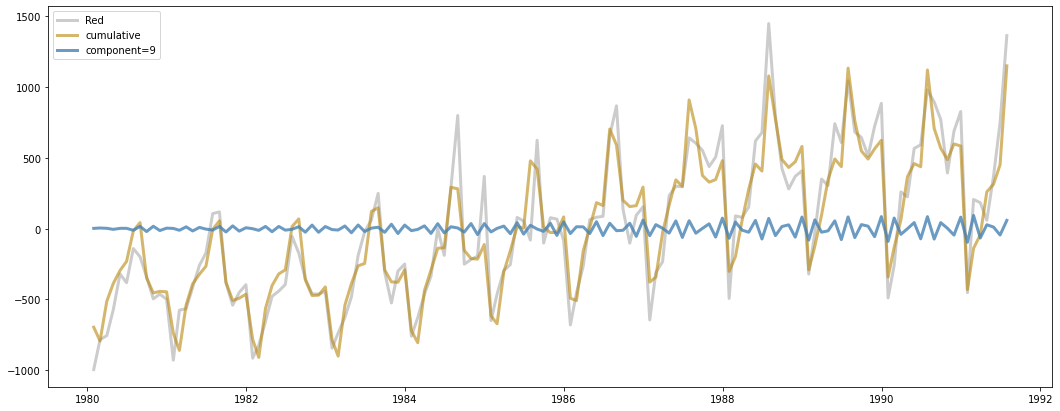

In [41]:
red_idx = 3

cumulative_recon = np.zeros_like(wine_tr.iloc[:, red_idx].values)

for comp in range(10):  
    fig, ax = plt.subplots(figsize=(18, 7))
    current_component = mssa.components_[red_idx, :, comp]
    cumulative_recon = cumulative_recon + current_component
    
    ax.plot(wine_tr.index, wine_tr.iloc[:, red_idx].values, lw=3, alpha=0.2, c='k', label=wine_tr.columns[red_idx])
    ax.plot(wine_tr.index, cumulative_recon, lw=3, c='darkgoldenrod', alpha=0.6, label='cumulative'.format(comp))
    ax.plot(wine_tr.index, current_component, lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    
    ax.legend()
    plt.show()

### `component_ranks_` and `component_ranks_explained_variance_`

While the components corresponding to more variance explained for each timeseries are more likely to be in the first components than later components, the "optimal" order is not necessarily the same for each fit timeseries. For example, component 0 may explain the most variance out of all components for for timeseries 1, but component 3 may explain the most for timeseries 2.

You can access the ranks of components for each timeseries from the `component_ranks_` attribute. These ranks are calculated by ordering, for each timeseries, which components contribute the most variance explained. The matrix is shape (n_components, P), where P is the number of timeseries.

In [42]:
mssa.component_ranks_[0:10]

array([[ 0,  2,  2,  7,  4,  2,  7],
       [ 1,  3,  3,  4,  7,  3,  4],
       [ 2,  0,  7,  2,  2,  5,  5],
       [ 3,  1,  4,  3,  3,  6,  2],
       [ 7, 10,  5,  5,  5,  1,  3],
       [ 5,  8,  0,  0,  1,  0, 40],
       [ 6,  5,  1,  1, 11,  7,  6],
       [ 9,  9,  6,  6, 10,  8,  1],
       [ 8,  7, 10, 10,  0,  9,  0],
       [10, 11, 11,  9,  8, 12, 43]])

This can be useful information for choosing the fewest number of components to represent a timeseries. The percent variance explained corresponding to these rank-ordered components can be found in the matrix `component_ranks_explained_variance_`.

In [43]:
mssa.component_ranks_explained_variance_[0:10]

array([[0.26045081, 0.21919537, 0.35459922, 0.28545308, 0.14046339,
        0.34817996, 0.40736866],
       [0.23162594, 0.19275432, 0.32554651, 0.30426961, 0.24542234,
        0.3285993 , 0.37937524],
       [0.17795832, 0.1915787 , 0.14050118, 0.22456398, 0.13143347,
        0.10534724, 0.19917416],
       [0.1253255 , 0.15783665, 0.11418616, 0.22094286, 0.09371774,
        0.11122531, 0.13946752],
       [0.10977598, 0.05959656, 0.079169  , 0.12709454, 0.09939592,
        0.13692711, 0.06289897],
       [0.10959075, 0.05598635, 0.09753181, 0.07397155, 0.06880002,
        0.13704857, 0.0282961 ],
       [0.06945603, 0.06800126, 0.09194293, 0.04791   , 0.04254097,
        0.03483447, 0.03898104],
       [0.061113  , 0.0534627 , 0.04502527, 0.02556937, 0.04279967,
        0.04335638, 0.03505324],
       [0.06073834, 0.04613676, 0.02186256, 0.01485315, 0.06691956,
        0.04249523, 0.03799466],
       [0.04049725, 0.05266465, 0.01902912, 0.02494359, 0.03443147,
        0.02295795, 0.0

## The w-correlation matrix

The w-correlation is a common metric used in SSA for measuring the correlation between components. Due to the fact that SVD is performed on trajectory matrices and then the reconstruction is done by converting the reconstructed trajectory matrices (elementary matrices) back into timeseries vectors via diagonal averaging, the reconstructed timeseries are not guaranteed to be orthogonal. There is a good chance that some timeseries components are highly correlated and should be "grouped" together (via adding together).

The w-correlation is a weighted correlation that takes into account the fact that some timepoints appear more frequently in the trajectory matrix than others. For example, timepoint 1 will only appear once in the trajectory matrix, while others in the middle of a timeseries can appear up to window-size L times.

You can diagnose what components you would like to group together as well as how many you should keep by calculating and plotting the w-correlation matrix. Below I'll plot out the w-correlation matrix for "Total" (timeseries 0). The function `w_correlation` will give back the w-correlation matrix between components for a provided (N, n_components) reconstruction matrix.

In [44]:
total_comps = mssa.components_[0, :, :]
print(total_comps.shape)

(139, 71)


In [45]:
total_wcorr = mssa.w_correlation(total_comps)
total_wcorr_abs = np.abs(total_wcorr)

Text(0.5, 1.0, 'Total component w-correlations')

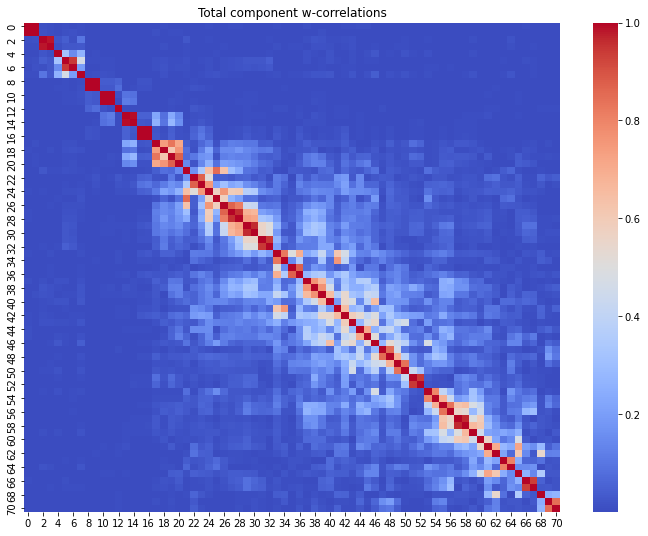

In [46]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(total_wcorr_abs), cmap='coolwarm', ax=ax)
ax.set_title('{} component w-correlations'.format(wine_tr.columns[0]))

In general you will want to group together components that are highly correlated with each other (done via the absolute value of w-correlation!). Components that have correlations with many other components are often deemed noise components and discarded.

In the plot above, we can see that there are maybe 11 groups of components before the components start to have "messy" correlation with the others. Grouping by looking at the w-correlation can be more of an art than a science. You may also choose to use some kindo of clustering algorithm providing the precomputed w-correlation matrix if you prefer a more algorithmic solution to grouping.

Below I put what I deem are the non-noise groupings in a list of lists, where each sub-list contains indicies of the components in a particular group.

In [47]:
# Groups for TS0, "Total"
ts0_groups = [
    [0,1],
    [2,3],
    [4],
    [5,6],
    [7],
    [8,9],
    [10,11],
    [12],
    [13,14],
    [15,16],
    [17,18,19,20]
]

## Assigning and accessing component groupings

After fitting the MSSA, there is an attribute labeled `component_groups_` that is a dictionary with timeseries indices as keys and a list of component indices as values. Initially, this defaults to having all components for each timeseries and each component in their own individual group.

You can manually set new groupings for a timeseries with one of two functions:
- `set_ts_component_groups`
- `set_component_groups`

The function `set_ts_component_groups` takes two arguments, the timeseries index and a list of lists specifying the groupings. We can use the list I made above to set the new groups for timeseries 0.

In [48]:
mssa.set_ts_component_groups(0, ts0_groups)
mssa.component_groups_[0]

[[0, 1],
 [2, 3],
 [4],
 [5, 6],
 [7],
 [8, 9],
 [10, 11],
 [12],
 [13, 14],
 [15, 16],
 [17, 18, 19, 20]]

Now we have set specific groups of components for timeseries 0. The `set_component_groups` function alternatively takes a dictionary of timeseries index keys and values of lists of lists for group indices if you want to set multiple timeseries groupings at once (or just prefer to do it with a dictionary).

The attribute `grouped_components_` generates component matrices that follow the specifications laid out in the `component_groups_` dictionary. If we now access timeseries index 0 of `grouped_components_`, you can see that the matrix has 11 components which are created by adding together the components we specified in our groups.

In [49]:
ts0_grouped = mssa.grouped_components_[0]
ts0_grouped.shape

(139, 11)

We can look at the w-correlation for the grouped components to validate that we have removed most of the correlation between components by grouping.

Text(0.5, 1.0, 'Total grouped component w-correlations')

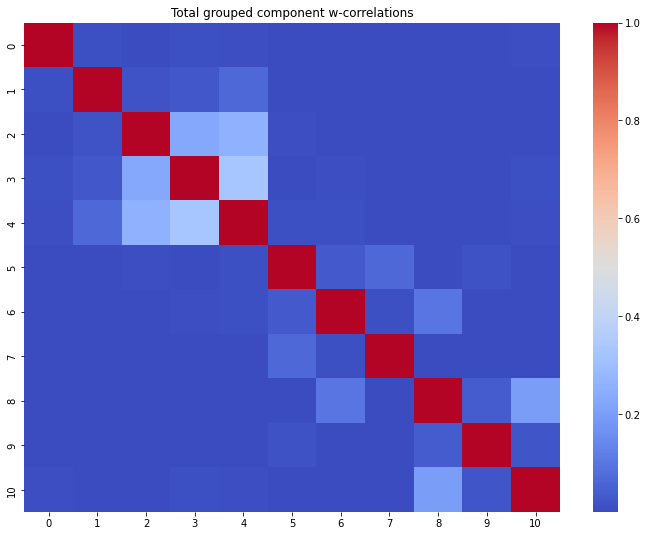

In [50]:
ts0_grouped_wcor = mssa.w_correlation(ts0_grouped)
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(ts0_grouped_wcor), cmap='coolwarm', ax=ax)
ax.set_title('{} grouped component w-correlations'.format(wine_tr.columns[0]))

## Automatic selection of `n_components`

During the instantiation of the `MSSA` object there are also some options for the `n_components` argument that allow for different methods of automatic number of component selection. This can be useful if you don't have an idea how many components should be kept, but dont want to compute the entire matrices of components for each timeseries due to time or space constraints.

The available options are:
- `n_components = 'svht'`
    - Select the number of components using the "Singular Value Hard Thresholding" formula. This is a way to determine the number of components based on a formula threshold, [as detailed in this paper](https://arxiv.org/pdf/1305.5870.pdf).
- `n_components = 'parallel_analysis'`
    - Select the number of components using the parallel analysis method. This constructs multiple "noise" matrices of the same shape as your input matrix, and will select the number of components for your real data who's eigenvalues exceed a user-specified percentile of the noise eigenvalues (typically 95th percentile is used). This is a gold standard strategy for selecting number of components in PCA and has been adapted here to for the special trajectory matrix format of MSSA. Note that this will be the slowest automated strategy by a long shot. You can control the percentile used by parallel analysis with the `pa_percentile_threshold` argument.
- `n_components = 'variance_threshold'`
    - This will discard any components beyond the user specified threshold in the argument `variance_explained_threshold`. The cumulative variance explained is calculated for the singular values/vectors, and only those <= the threshold are retained.
    
Below I'll compare the number of components kept using each of these strategies.

In [51]:
mssa = MSSA(n_components='svht',
            window_size=None,
            verbose=True)
mssa.fit(wine_tr)
print(mssa.components_.shape)

Constructing trajectory matrix
Trajectory matrix shape: (483, 71)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 13 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders
(7, 139, 13)


In [52]:
mssa = MSSA(n_components='variance_threshold',
            variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
mssa.fit(wine_tr)
print(mssa.components_.shape)

Constructing trajectory matrix
Trajectory matrix shape: (483, 71)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 20 according to variance explained threshold
Constructing components
Calculating optimal reconstruction orders
(7, 139, 20)


In [53]:
mssa = MSSA(n_components='parallel_analysis',
            pa_percentile_threshold=95,
            window_size=None,
            verbose=True)
mssa.fit(wine_tr)
print(mssa.components_.shape)

Constructing trajectory matrix
Trajectory matrix shape: (483, 71)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 8
Constructing components
Calculating optimal reconstruction orders
(7, 139, 8)


We can see that (using the default settings), parallel analysis is the most conservative, variance explained thresholding is the least conservative, and svht falls somewhere in between on the more conservative side.

Note that the components retained will not be in any way different than the components you would get out without a thresholding strategy. This just removes what it deems are the "noise" components.

## Forecasting with MSSA

Lastly we can also perform forecasts using the `forecast` function. This function takes these arguments:
    - `timepoints_out` the number of timepoints past training we would like to forecast out.
    - `timeseries_indices` is the indices of timeseries you want to forecast for (if None, forecasts all timeseries).
    - `use_components` is an array of component indices you would like to use to do the forecasting for. If None, uses all the components.
    
I will use the last `mssa` object I fit that used parallel analysis thresholding, and forecast out the testing indices we set up awhile back using all the components. Normally you would want to select a smaller set of components, but since we have already used some stringent thresholding during the fitting procedure we can just use all the remaining components for the forecast and not have to worry as much about overfitting issues.

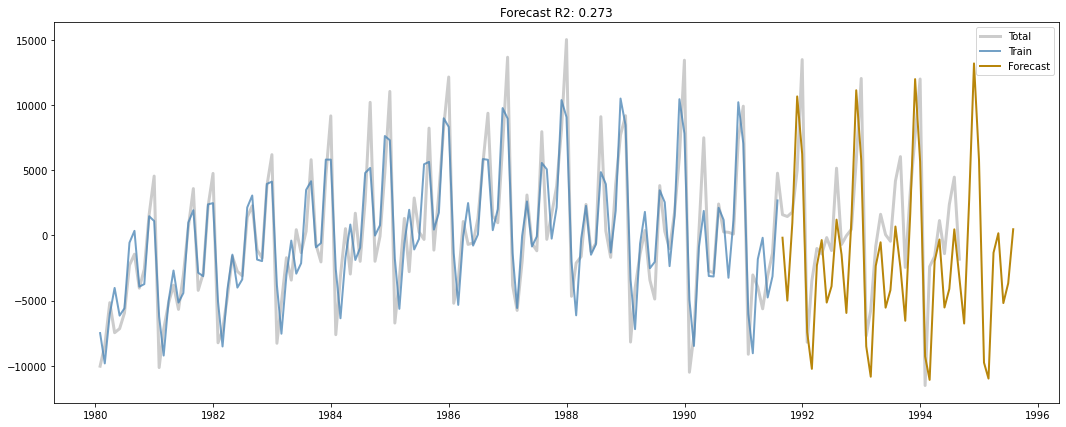

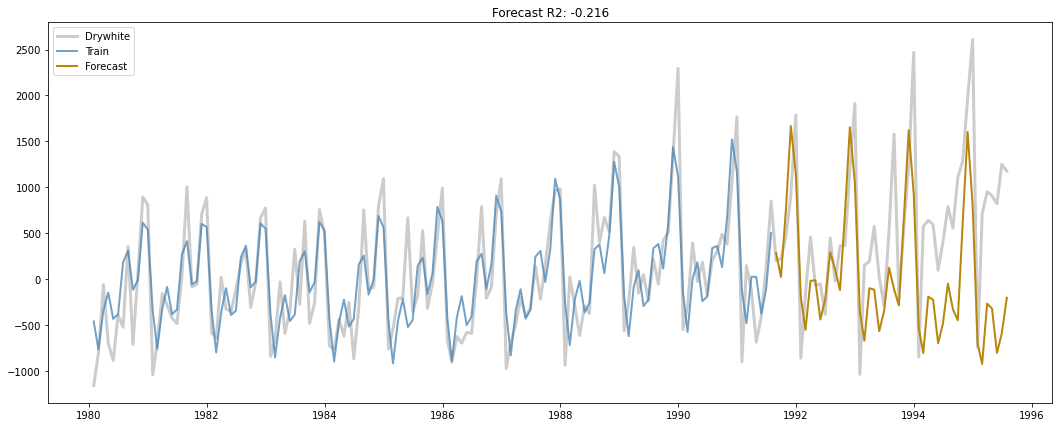

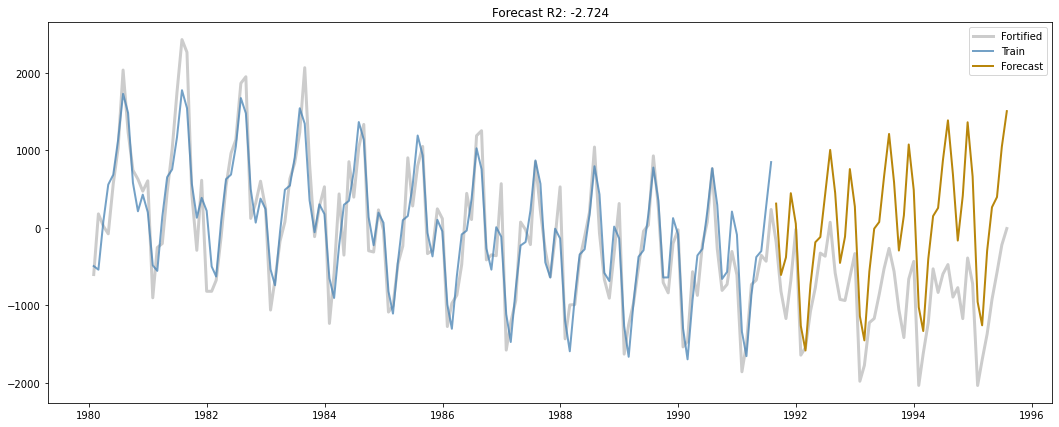

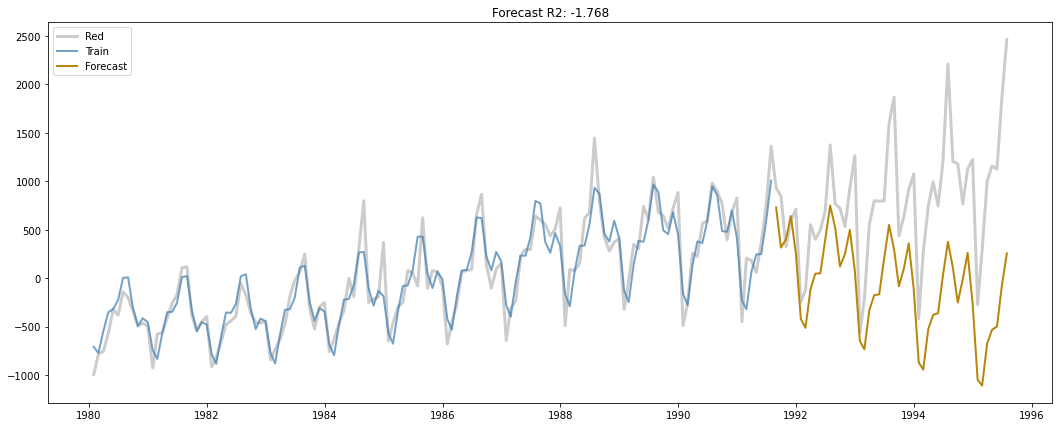

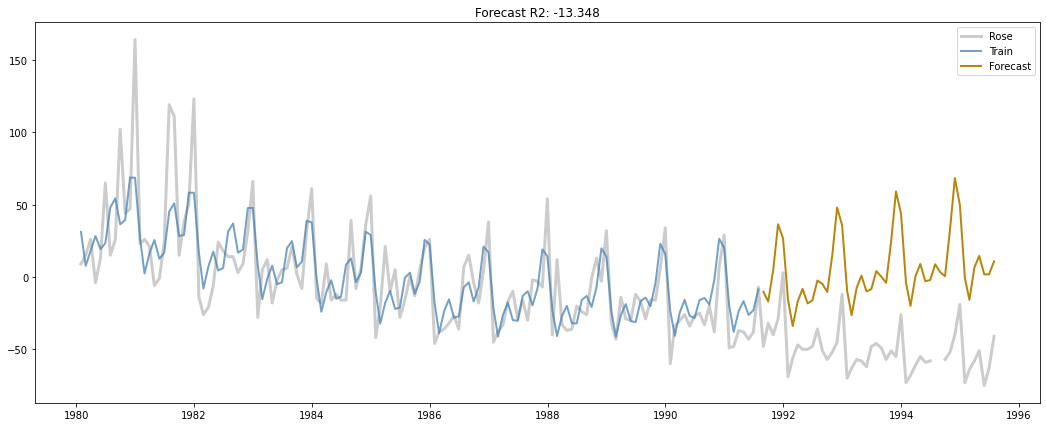

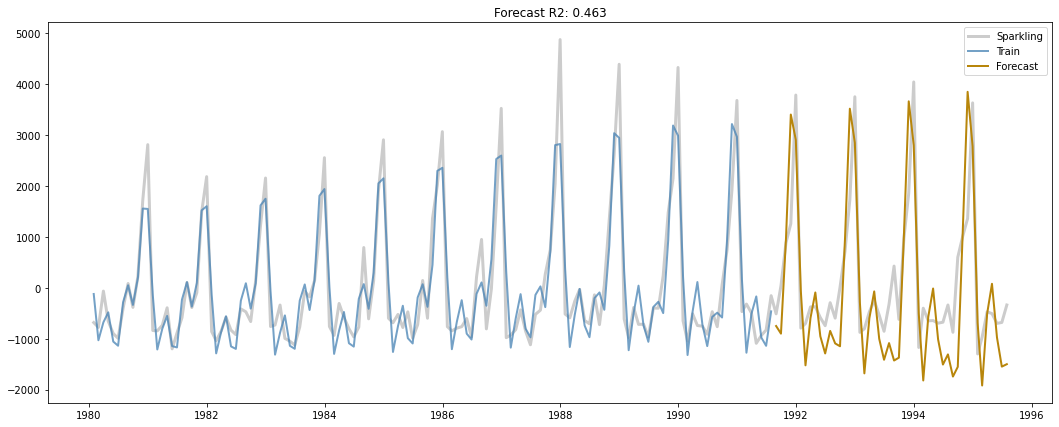

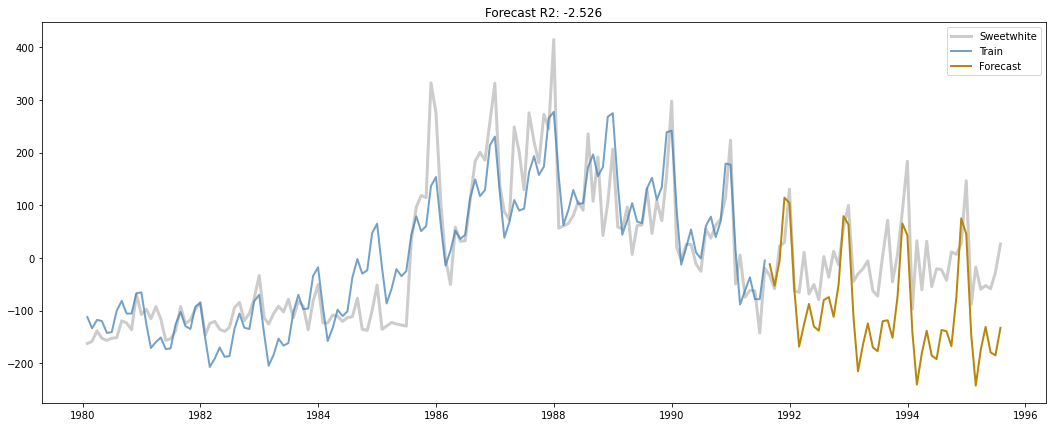

In [54]:
wine_c = wine - tr_means

for ts_index in range(wine_c.shape[1]):
    tr = np.zeros(wine_c.shape[0])
    tr[:] = np.nan

    te = np.copy(tr)

    tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
    fc = mssa.forecast(tp, timeseries_indices=ts_index)
    
    ytrue = wine_te.iloc[:, ts_index].values
    yhat = fc.ravel()[~pd.isnull(ytrue)]
    ytrue = ytrue[~pd.isnull(ytrue)]
    
    r2 = r2_score(ytrue, yhat)
    te[-tp:] = fc

    fig, ax = plt.subplots(figsize=(18, 7))
    ax.plot(wine_c.index, wine_c.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=wine_c.columns[ts_index])
    ax.plot(wine_c.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
    ax.plot(wine_c.index, te, lw=2, c='darkgoldenrod', label='Forecast')
    ax.set_title('Forecast R2: {:.3f}'.format(r2))
    ax.legend()
    
    plt.show()

---
# Contributing & TODO

All contributions are more than welcome to the `pymssa` package! There is still a ton of things that can be added to make this a more comprehensive MSSA package; I've really only scratched the surface here. I am also not an MSSA expert, so if you are I would welcome any feedback, corrections, etc. that you may have.

Here is a list of some things that come to mind that are not part of this package yet but that could definitely be added, if you are looking for ideas:
- Tests! (I should really do this)
- Vectorized forecasting formula. Apparently this leads to higher forecasting accuracy and currently the recurrent formula is the one implemented.
- Sequential SSA
- Better automated grouping of components (e.g. via the periodogram)
- Vizualization and diagnostic tools
- Reconstruction of components via FFT (I believe this is how Rssa does it)
- Bootstrap forecasting and confidence intervals
- Oblique and Nested Oblique MSSA
- Imputation via MSSA
- Function to calculate the Heterogeneity matrix (H-Matrix)
- Summary functions and printouts with relevant statistics on fits/decomposition/forecasts.
- ... and probably many more